In [1]:
import sys
sys.path.append('../')
import pandas as pd
import numpy as np

# module loading settings
%load_ext autoreload
%autoreload 2

In [2]:
import json

with open('../data/partijen-metadata.json', 'r') as f:
     meta = json.load(f)

party_dict = {}
for party_data in meta['partijen']:
    party_id = party_data['lijst']
    party_name = party_data['naam'].encode('utf-8')
    party_dict["{:02d}".format(party_id)] = party_name

In [3]:
# from src.preprocessing import pdf_to_df
# raw = pdf_to_df(data_dir='../data/')

raw = pd.read_csv('../data/processed/dataframe.csv') 
raw['file'] = raw['file'].replace(to_replace=party_dict, regex=True).apply(lambda x: x.split('-')[1])
raw.rename(columns={'file': 'party'}, inplace=True)

raw.head()

,party,text
0,PVDA,n e d n o b r e v n ee g n i v e l sa m e n ve...
1,SGP,foto voorkant niek stam fotografie s...
2,Ondernemerspartij,verkiezingsprogramma november veilig...
3,Libertarische Partij,verkiezingsprogramma libertarische partij ...
4,Lokaal in de Kamer,programma het programma van lokaal in de kamer...


In [4]:
def chunk_string(string, length):
    return [string[0+i:length+i] for i in range(0, len(string), length)]

df = raw['text'].apply(lambda x: pd.Series(chunk_string(x, length=600))).stack().reset_index()
df.rename(columns={0: 'text'}, inplace=True)

print "{:d} text snippets".format(len(df))
df.head()

4897 text snippets


,level_0,level_1,text
0,0,0,n e d n o b r e v n ee g n i v e l sa m e n ve...
1,0,1,twerp paul pollmann inhoudsopgave essay ee...
2,0,2,rismebestrijding privacy justitie en rechtstaa...
3,0,3,ing werk en gezin pensioenen werkende ouderen ...
4,0,4,iedereen publieke waarden centraal van marktw...


In [7]:
df.loc[40,'text']

'en bestaan als winnaars niet accepteren dat er verliezers zijn  en als kansrijken investeren in kansarmen  wij staan een a   inclusievea    samenleving voor  waarin wij vanuit verbondenheid investeren in elkaar  wij willen de toenemende polarisatie keren door samen te zoeken naar wat ons bindt  en dan is er voor iedereen veel te winnen  daarin zit dan ook de opdracht besloten waar aan een volgend kabinet inhoud moet gaan geven  het gaat niet om de bv nederland maar om de samenleving zelf  daarom willen we in een komende kabinetsperiode een regering met een eenduidige missie  een missie waarin '

In [8]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.pipeline import Pipeline
from nltk.corpus import stopwords
from sklearn.decomposition import LatentDirichletAllocation

n_topics = 10

class TopicExtractorBuilder(self)

estimator = Pipeline(steps=[
        
    ('vectorizer', TfidfVectorizer(input='content', encoding='utf-8',
                                   decode_error='strict', strip_accents=None,
                                   lowercase=True, preprocessor=None, tokenizer=None,
                                   analyzer='word', stop_words=stopwords.words('dutch'), 
                                   ngram_range=(1, 1), max_df=0.95, min_df=2, max_features=1000,
                                   vocabulary=None, binary=False, dtype=np.int64,
                                   norm='l2', use_idf=True, smooth_idf=False, sublinear_tf=False)),
    
    ('model', LatentDirichletAllocation(n_topics=n_topics, doc_topic_prior=None, topic_word_prior=None,
                                        learning_method='online', learning_decay=0.7, learning_offset=10., 
                                        max_iter=10, batch_size=128, evaluate_every=-1, total_samples=1000000.0,
                                        mean_change_tol=0.001, max_doc_update_iter=100, n_jobs=1, verbose=0,
                                        random_state=42))])

estimator.fit_transform(df['text'].values)
estimator

Pipeline(steps=[('vectorizer', TfidfVectorizer(analyzer='word', binary=False, decode_error='strict',
        dtype=<type 'numpy.int64'>, encoding='utf-8', input='content',
        lowercase=True, max_df=0.95, max_features=1000, min_df=2,
        ngram_range=(1, 1), norm='l2', preprocessor=None, smooth_idf=Fa..._tol=0.1, random_state=42,
             topic_word_prior=None, total_samples=1000000.0, verbose=0))])

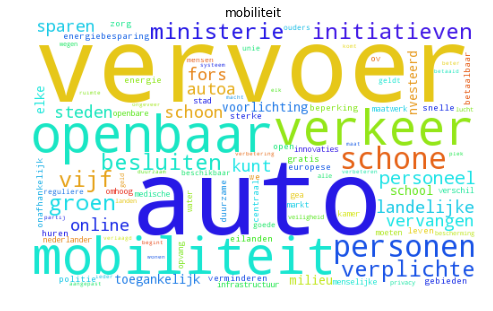

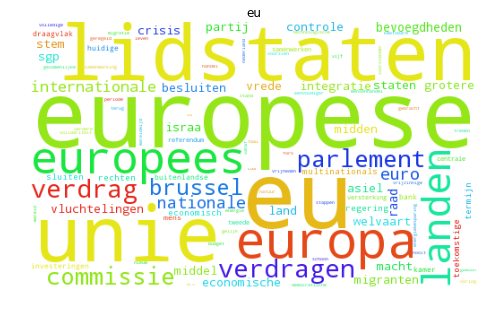

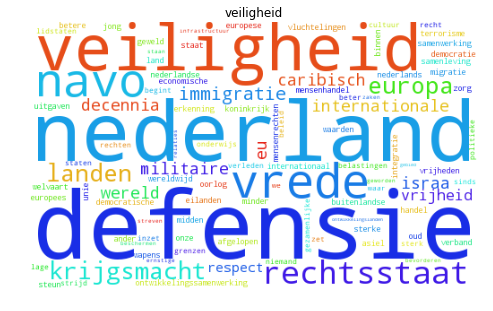

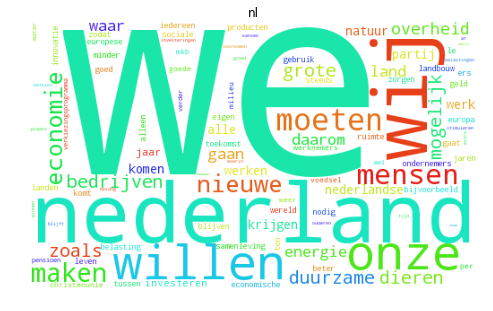

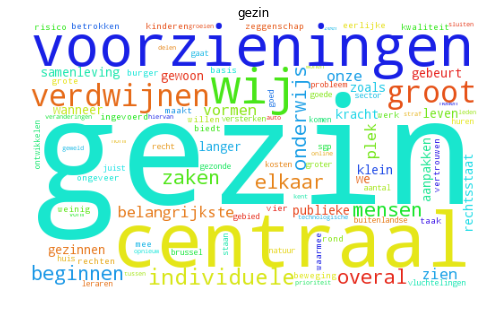

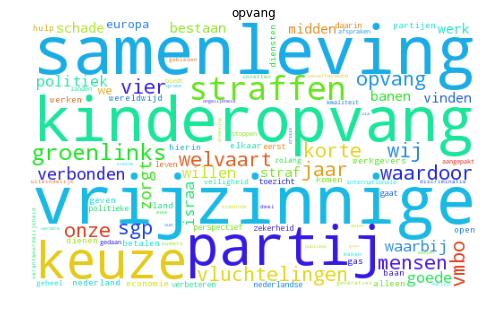

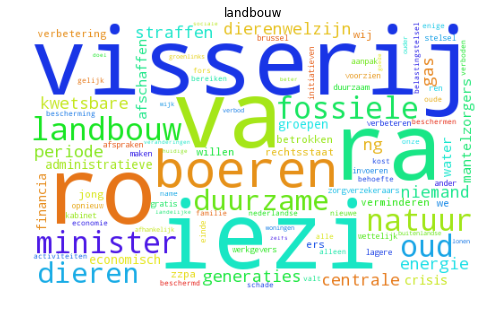

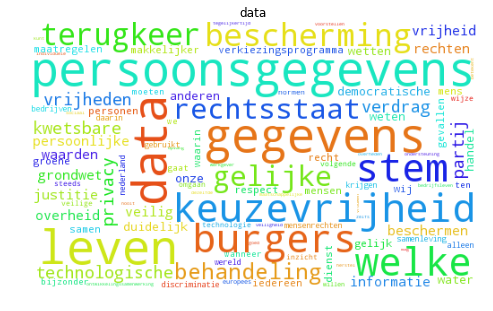

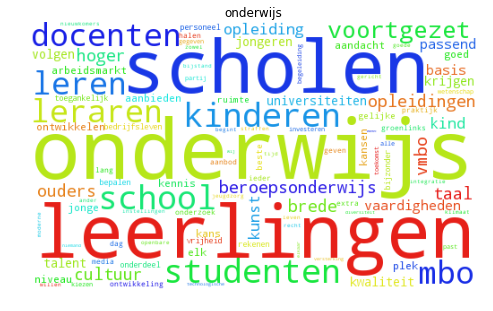

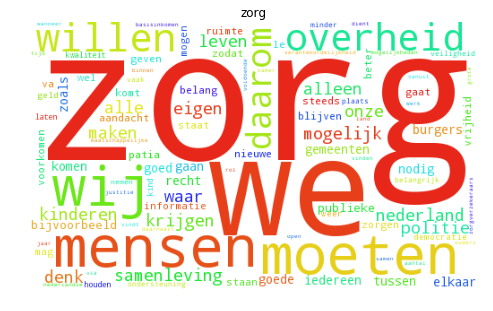

In [9]:
from wordcloud import WordCloud 
import matplotlib.pyplot as plt
%matplotlib inline

labels = ['mobiliteit','eu','veiligheid', 'nl','gezin','opvang','landbouw','data','onderwijs','zorg']

def plot_word_cloud(words, weights, max_words=100, title=None):   
        wc = WordCloud(background_color="white", max_words=max_words, width=500, height=300)
        wc.generate_from_frequencies(zip(words, weights))
        plt.figure(figsize=(8,6))
        plt.imshow(wc)
        plt.axis("off")
        plt.title(title)
        plt.show()
    
def plot_topics(words, components):
     for topic_idx, weights in enumerate(components):
            plot_word_cloud(words, weights, title=labels[topic_idx])

words = estimator.steps[0][1].get_feature_names()
components = estimator._final_estimator.components_

plot_topics(words, components)

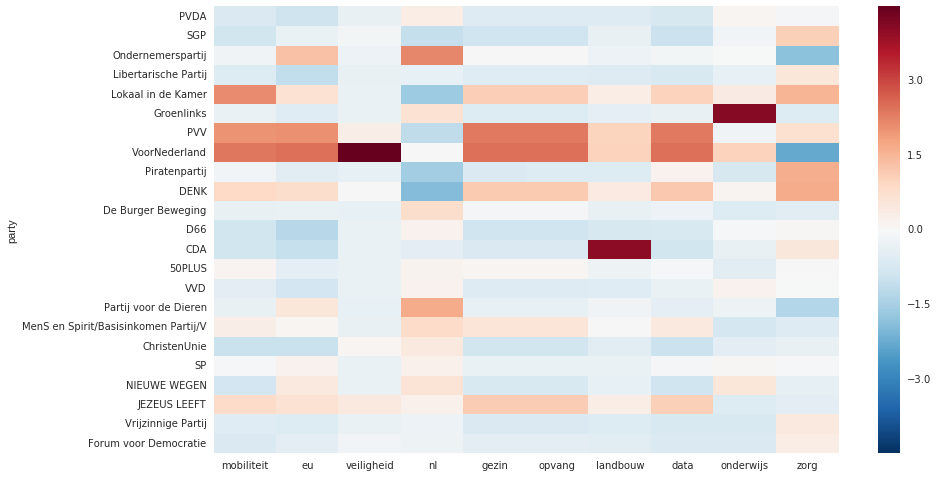

In [10]:
import seaborn as sns

party_labels = raw['party']

results = pd.DataFrame(estimator.transform(raw['text'].values))
results.columns = labels
results.index = party_labels

results_normalized = results.apply(lambda x: (x - x.min()) / (x.max()- x.min()), axis=0)
results_normalized = results.apply(lambda x: (x - x.mean()) / x.std(), axis=0)

fig, ax = plt.subplots(figsize=(14,8))   
sns.heatmap(results_normalized , ax=ax, annot=False)

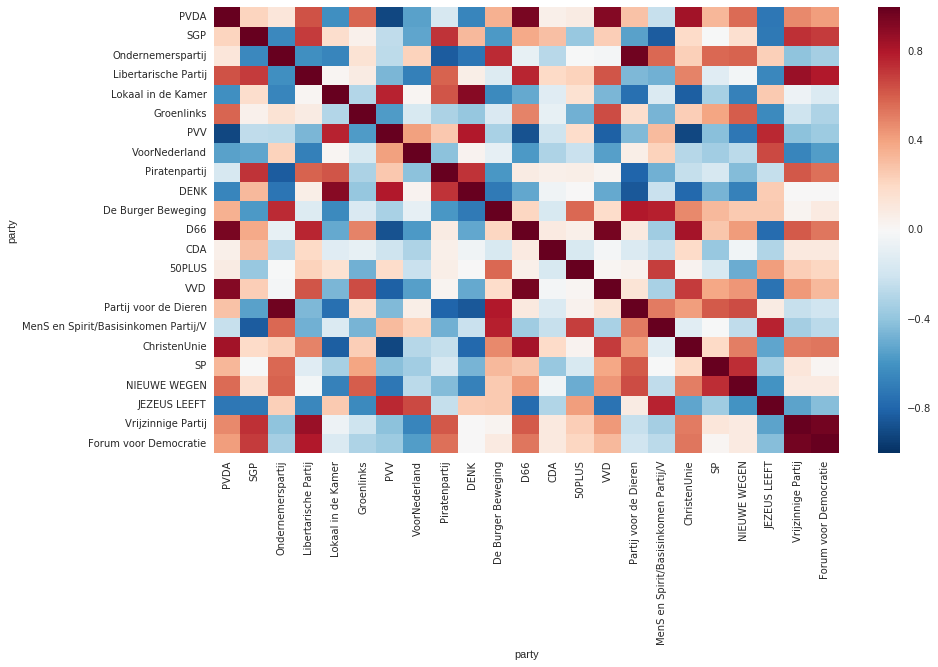

In [370]:
similarities = results_normalized.transpose().corr()

fig, ax = plt.subplots(figsize=(14,8))   
sns.heatmap(similarities, ax=ax)

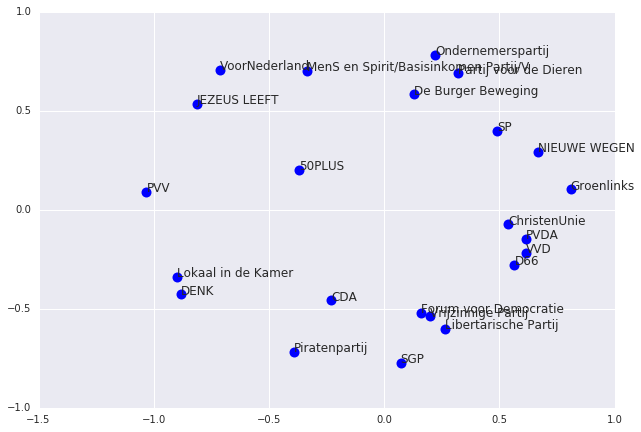

In [372]:
from sklearn.manifold import MDS

mds = MDS(n_components=2, max_iter=3000, eps=1e-9, random_state=33,
                   dissimilarity="precomputed", n_jobs=1)

pos = mds.fit(1-similarities.values).embedding_

fig = plt.figure(1)
ax = plt.axes([0., 0., 1., 1.])

s = 100
plt.scatter(pos[:, 0], pos[:, 1], s=s, lw=0, label='')
plt.legend(scatterpoints=1, loc='best', shadow=False)
for i, txt in enumerate(party_labels):
    ax.annotate(txt, (pos[i, 0],pos[i, 1]))

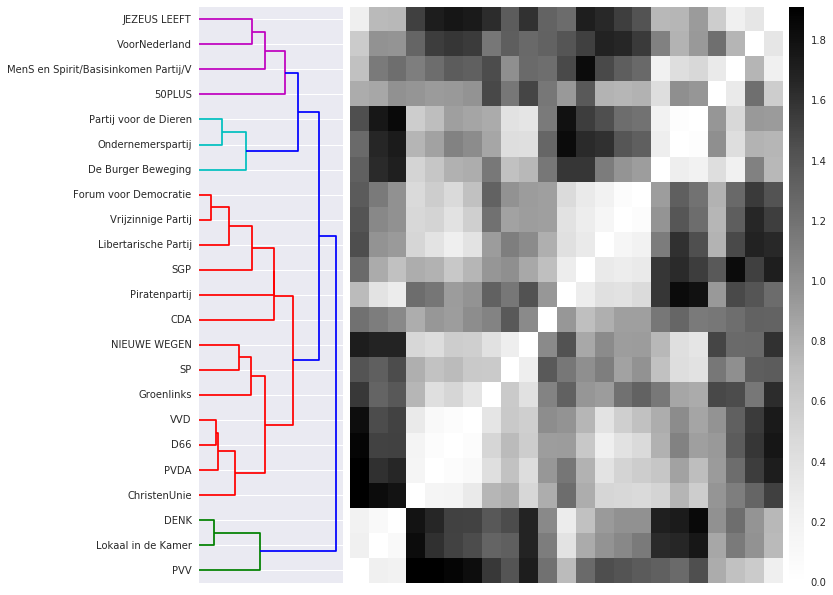

In [379]:
import scipy
import pylab
import scipy.cluster.hierarchy as sch

D = 1 - similarities.values

# Compute and plot dendrogram.
fig = pylab.figure(figsize=(10,10))
axdendro = fig.add_axes([0.09,0.1,0.2,0.8])
Y = sch.linkage(D, method='centroid')
Z = sch.dendrogram(Y, orientation='right')
axdendro.set_xticks([])


# Plot distance matrix.
axmatrix = fig.add_axes([0.3,0.1,0.6,0.8])
index = Z['leaves']
D = D[index,:]
D = D[:,index]
im = axmatrix.matshow(D, aspect='auto', origin='lower')
axmatrix.set_yticks([])
axmatrix.set_xticks([])

axdendro.set_yticklabels(party_labels[index])

# Plot colorbar.
axcolor = fig.add_axes([0.91,0.1,0.02,0.8])
pylab.colorbar(im, cax=axcolor)
